For this exercise, I plan on developing a predictive model that could identify "fake news" from new sources. The data set I've used specifically for this exercise comes from <a href='https://www.kaggle.com/c/fake-news/data'>Kaggle</a>.

In layman's term, "fake news" is news which contents are consider 'fake' or 'false'. Typically, you would need a sophisticated system of checks and source validations to verify whether or not such contents are 'true' or 'false'. For our purposes, we would assume that our labels are expertly reviewed and reliable.

For this data set, we're limited to 5 columns:
- id: the unique numeric identifier for the news
- title: the name of the news
- author: the entity that wrote the news
- text: the actual content of the story
- label: an identifier that labels whether or not the news source is reliable (0) or unreliable (1).

Labels aside, there are three features of interest: the title, the author, and the text. With these string data, we could train a model that predicts 'fake news' using the type of words being used from every column. For the model to read this data, we could turn our string data into a word vector. 

In [1]:
# Import core dependencies
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Building local path to data file
work_dir = os.getcwd()
main_dir = os.path.dirname(work_dir)
data_files_dir = os.path.join(main_dir, 'data_files')
data_file_train = os.path.join(data_files_dir, 'train.csv')
data_file_test = os.path.join(data_files_dir, 'test.csv')
data_file_validation = os.path.join(data_files_dir, 'submit.csv')

# Loading data file ("train.csv") as DataFrame
df = pd.read_csv(data_file_train)

In [3]:
# Checking data structure
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
# Checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
# Checking nulls from title column
df[df['title'].isna() == True].head()

,id,title,author,text,label
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1
196,196,NaN,Raffie,They got the heater turned up on high.,1


In [6]:
# Checking nulls from author column
df[df['author'].isna() == True].head()

,id,title,author,text,label
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1


In [7]:
# Checking nulls from text column
df[df['text'].isna() == True].head()

,id,title,author,text,label
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1


For NaNs, we could replace them with 'notitle', 'noauthor', and 'notext' respective.

In [8]:
# Replace NaNs with fillers: 'notitle', 'noauthor', 'notext'
df['title'] = df['title'].fillna('notitle')
df['author'] = df['author'].fillna('noauthor')
df['text'] = df['text'].fillna('notext')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20800 non-null  object
 2   author  20800 non-null  object
 3   text    20800 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


From a glance, it's obvious that English isn't the only language the dataset contains. But these string data could nevertheless be processed using a text vectorizer. We'll build our training set using this DataFrame. Before we process our data any further, we can collapse the three columns into one, merging the three smaller strings into one large string.

Before we do that however, there were something of note inside our string data, notably \n, which are used when creating a newline. It is clear that these data were scraped from some online source, thus we might want to clean them a bit further before utilizing them. We could start seeing how many \n are in our data and remove them.

In [10]:
# Checking for '\n' specifically
print("Number of '\\n' in text: {}".format(df['title'].str.contains('\\n').sum()))
print("Number of '\\n' in text: {}".format(df['author'].str.contains('\\n').sum()))
print("Number of '\\n' in text: {}".format(df['text'].str.contains('\\n').sum()))

Number of '\n' in text: 0
Number of '\n' in text: 0
Number of '\n' in text: 8160


In [11]:
# Checking few rows with '\n'
df[df['text'].str.contains('\\n') == True].head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,noauthor,Ever wonder how Britain’s most iconic pop pian...,1


In [12]:
# Replacing '\n' with spaces
df['text'] = df['text'].str.replace('\\n',' ')

/Users/Lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [13]:
# Confirming '\n' is replaced
print("Number of '\\n' in text: {}".format(df['text'].str.contains('\\n').sum()))

Number of '\n' in text: 0


In [14]:
# Checking id=4 where we visually saw '\n' in the text
df[df['id'] == 4]

,id,title,author,text,label
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to ...,1


Given the data is likely web-scraped, we'll also look out for CSS-style tags like \<a href=\> or \</a\>, etc.

In [15]:
# Checking for CSS-style tags
print("Number of CSS-style tags in text: {}".format(df['title'].str.contains(r'<.*?>', regex=True).sum()))
print("Number of CSS-style tags in text: {}".format(df['author'].str.contains(r'<.*?>', regex=True).sum()))
print("Number of CSS-style tags in text: {}".format(df['text'].str.contains(r'<.*?>', regex=True).sum()))

Number of CSS-style tags in text: 0
Number of CSS-style tags in text: 0
Number of CSS-style tags in text: 90


In [16]:
# Checking few rows with tags
df[df['text'].str.contains(r'<.*?>', regex=True) == True].head()

,id,title,author,text,label
563,563,Coming Unglued,John Kaminski,"By John Kaminski on October 30, 2016 John Kami...",1
826,826,"Syrian War Report – November 14, 2016: Govt Fo...",The Saker,Leave a Reply Click here to get more info on f...,1
1538,1538,NEW Donna Brazile email shows more questions g...,noauthor,NEW Donna Brazile email shows more questions g...,1
1539,1539,Podesta emails - Re: Obama Says He Didn’t Know...,Mike Rivero,View source Re: Obama Says He Didn’t Know Hill...,1
1623,1623,Deterioration of Interracial Relations During ...,The Saker,Leave a Reply Click here to get more info on f...,1


In [17]:
# Checking specific tags
tags = []
for i in list(df[df['text'].str.contains(r'<.*?>', regex=True) == True].text.values):
    tags.append(re.findall(r'<.*?>', i))

print(tags)

[['< http://www.globalresearch.ca/isis-beheadings-of-journalists-cia-admitted-to-staging-fake-jihadist-videos-in-2010/5399345 >'], ['<b>', '</b>', '<i>', '</i>', '<em>', '</em>', '<strong>', '</strong>', '<q>', '</q>', '<cite>', '</cite>', '<blockquote>', '</blockquote>', "<a href=''http://link-address.com''>", '</a>'], ['<donna@brazileassociates.com>', '<john.podesta@gmail.com>', '<donna@brazileassociates.com>', '<john.podesta@gmail.com>', '<jpalmieri@hillaryclinton.com>', '<aelrod@hillaryclinton.com>', '<Minyon.Moore@deweysquare.com>', '<088DA582-5DFC-46B9-8767-0EB2FE42E57D@brazileassociates.com>', '<87E4B303477C2E41BFCAF7FE920279AB@mex05.mlsrvr.com>'], ['<jennifer.m.palmieri@gmail.com<mailto:jennifer.m.palmieri@gmail.com>', '<pir@hrcoffice.com<mailto:pir@hrcoffice.com>', '<pir@hrcoffice.com>', '<pir@hrcoffice.com>', '<jennifer.m.palmieri@gmail.com>', '<john.podesta@gmail.com>', '<cheryl.mills@gmail.com>', '<nmerrill@hrcoffice.com>', '<hsamuelson@cdmillsgroup.com>', '<17B2908F-F9FA-4

Looking at these tags, we could see most of them are definitely CSS tags. Other things include email address and a few  lengthy passages, mainly part of the span tag.

Perhaps we could keep them as they are append to the contents of the text, but the amount of data here is exceedingly small (size of 90) vs the amount of data we have in our dataset (size 20800). This amounts to less than 1% of our data (around 0.4%), thus we could safely assume that the removal of this content would have negliable impact on the model we develop.

In [18]:
# Replacing tags with spaces
df['text'] = df['text'].str.replace(r'<.*?>',' ', regex=True)

In [19]:
print("Number of CSS-style tags in text: {}".format(df['text'].str.contains(r'<.*?>', regex=True).sum()))

Number of CSS-style tags in text: 0


While there could be other potential characters that might need to be address such as special characters or emojis, we could consider them in the future if the clean up to this point appears insufficient after we trained our predictive model.

For now, we'll merge our columns together into one and create one large string under the column merged. We'll leave label alone (that'll be our target) and we'll make merged our feature.

In [20]:
# Creating merged column
df['merged'] = df['title'] + ' ' + df['author'] + ' ' + df['text']
df

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print An Iranian woman has been sentenced to ...,1,Iranian woman jailed for fictional unpublished...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,Rapper T.I.: Trump a ’Poster Child For White S...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,Macy’s Is Said to Receive Takeover Approach by...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [21]:
# Separating target from the rest of the data
X = df['merged']
y = df['label']

At this time, our string data is still in the form of words. In order for us to build a machine learning model for this dataset, we need to convert the strings into a vector. This can be done using sci-kit learn's text extraction functions, CountVectorizer and TfidfVectorizer.

In [22]:
# Import dependencies to vectorize string data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
# Initializing vectorizers
countvec = CountVectorizer()
tfidfvec = TfidfVectorizer()

In [24]:
# Building vectorizer vocabulary, CountVec
countvec.fit(X)

CountVectorizer()

In [25]:
# Building vectorizer vocabulary, TfidfVec
tfidfvec.fit(X)

TfidfVectorizer()

In [26]:
# Transforming into arrays
X_countvec = countvec.transform(X)
X_tfidfvec = tfidfvec.transform(X)

In [27]:
# Checking sparse matrix
X_countvec

<20800x181975 sparse matrix of type '<class 'numpy.int64'>'
	with 6956587 stored elements in Compressed Sparse Row format>

In [28]:
# Checking sparse matrix
X_tfidfvec

<20800x181975 sparse matrix of type '<class 'numpy.float64'>'
	with 6956587 stored elements in Compressed Sparse Row format>

Let us set up the test data from test.csv and submit.csv in the same format as the training data now before building our machine learning pipeline.

In [29]:
df_test = pd.read_csv(data_file_test)
df_test

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...
5198,25998,300 US Marines To Be Deployed To Russian Borde...,NaN,« Previous - Next » 300 US Marines To Be Deplo...


In [30]:
df_test_labels = pd.read_csv(data_file_validation)
df_test_labels

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1
...,...,...
5195,25995,0
5196,25996,1
5197,25997,0
5198,25998,1


In [31]:
df_test = df_test.merge(df_test_labels, on='id', how='left')
df_test

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1
...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,NaN,« Previous - Next » 300 US Marines To Be Deplo...,1


In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
 4   label   5200 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 243.8+ KB


In [33]:
# Like before we'll replace NaNs with fillers
df_test['title'] = df_test['title'].fillna('notitle')
df_test['author'] = df_test['author'].fillna('noauthor')
df_test['text'] = df_test['text'].fillna('notext')

# Replacing '\n' with spaces
df_test['text'] = df_test['text'].str.replace('\\n',' ')

# Replacing tags with spaces
df_test['text'] = df_test['text'].str.replace(r'<.*?>',' ', regex=True)

/Users/Lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [34]:
# We'll also create a merged column to match the formate of our training set
df_test['merged'] = df_test['title'] + ' ' + df_test['author'] + ' ' + df_test['text']

In [35]:
# Separating target from the rest of the test data
X_test = df_test['merged']
y_test = df_test['label']

In [36]:
# Transforming into arrays
X_countvec_test = countvec.transform(X_test)
X_tfidfvec_test = tfidfvec.transform(X_test)

In [37]:
X_countvec_test

<5200x181975 sparse matrix of type '<class 'numpy.int64'>'
	with 1741288 stored elements in Compressed Sparse Row format>

In [38]:
X_tfidfvec_test

<5200x181975 sparse matrix of type '<class 'numpy.float64'>'
	with 1741288 stored elements in Compressed Sparse Row format>

With our datasets ready, let's build our machine learning pipeline. For this dataset, we're here to find out whether or not a news article is 'fake news'. As such, we can turned into a binary classification problem with the word vectors as our features. For classification, we could try out several kind: Logistic Regression, Random Forest, Gradiant Boosting, and Naive Bayes. We'll also optimize for hyperparameters using cross-validation.

To speed up the search for more costly approaches like Random Forest and Gradient Boosting, I'll use a randomized search for these methods. If these methods does prove to be better than Logistic Regression or Naive Bayes, I'll run a more rigorous grid check for hyperparameters.

In [120]:
# Import dependencies for machine learning model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve

In [40]:
# Setting up pipeline with each classifcation model
pipe_countvec_logreg = Pipeline([('clf_logreg', LogisticRegression())])
pipe_tfidfvec_logreg = Pipeline([('clf_logreg', LogisticRegression())])

pipe_countvec_naivebayes = Pipeline([('clf_naivebayes', MultinomialNB())])
pipe_tfidfvec_naivebayes = Pipeline([('clf_naivebayes', MultinomialNB())])

pipe_countvec_randfor = Pipeline([('clf_randfor', RandomForestClassifier())])
pipe_tfidfvec_randfor = Pipeline([('clf_randfor', RandomForestClassifier())])

pipe_countvec_gradboost = Pipeline([('clf_gradboost', GradientBoostingClassifier())])
pipe_tfidfvec_gradboost = Pipeline([('clf_gradboost', GradientBoostingClassifier())])

# Setting up hyperparameters for each classification model
parameters_logreg = {'clf_logreg__solver': ['newton-cg'],
                     'clf_logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                     'clf_logreg__random_state': [42]}

parameters_naivebayes = {'clf_naivebayes__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0]}

parameters_randfor = {'clf_randfor__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
                      'clf_randfor__max_depth': [3, 4, 5],
                      'clf_randfor__max_features': ['sqrt','log2'],
                      'clf_randfor__random_state': [42]}

parameters_gradboost = {'clf_gradboost__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
                        'clf_gradboost__max_depth': [3, 4, 5],
                        'clf_gradboost__learning_rate': [0.01, 0.05, 0.1, 0.2],
                        'clf_gradboost__max_features': ['sqrt','log2'],
                        'clf_gradboost__random_state': [42]}

In [41]:
# Run grid search with 5-fold cross validation for Logistic Regression
grid_countvec_logreg_5cv = GridSearchCV(pipe_countvec_logreg, parameters_logreg, cv=5).fit(X_countvec, y)
grid_tfidfvec_logreg_5cv = GridSearchCV(pipe_tfidfvec_logreg, parameters_logreg, cv=5).fit(X_tfidfvec, y)

In [42]:
# Run grid search with 5-fold cross validation for Naive Bayes
grid_countvec_naivebayes_5cv = GridSearchCV(pipe_countvec_naivebayes, parameters_naivebayes, cv=5).fit(X_countvec, y)
grid_tfidfvec_naivebayes_5cv = GridSearchCV(pipe_tfidfvec_naivebayes, parameters_naivebayes, cv=5).fit(X_tfidfvec, y)

In [43]:
# Run randomized search with 5-fold cross validation for Random Forest and Gradient Boosting
grid_countvec_randfor_5cv = RandomizedSearchCV(pipe_countvec_randfor, parameters_randfor, cv=5).fit(X_countvec, y)
grid_tfidfvec_randfor_5cv = RandomizedSearchCV(pipe_tfidfvec_randfor, parameters_randfor, cv=5).fit(X_tfidfvec, y)

In [44]:
# Run randomized search with 5-fold cross validation for Gradient Boosting
grid_countvec_gradboost_5cv = RandomizedSearchCV(pipe_countvec_gradboost, parameters_gradboost, cv=5).fit(X_countvec, y)
grid_tfidfvec_gradboost_5cv = RandomizedSearchCV(pipe_tfidfvec_gradboost, parameters_gradboost, cv=5).fit(X_tfidfvec, y)

In [45]:
# List of grids searched
grids_countvec = [grid_countvec_logreg_5cv,
                  grid_countvec_naivebayes_5cv,
                  grid_countvec_randfor_5cv,
                  grid_countvec_gradboost_5cv]

grids_tfidfvec = [grid_tfidfvec_logreg_5cv,
                  grid_tfidfvec_naivebayes_5cv,
                  grid_tfidfvec_randfor_5cv,
                  grid_tfidfvec_gradboost_5cv]

# Dictionary of classifiers
grid_dict_countvec = {0: 'Logistic Regression',
                      1: 'Naive Bayes', 
                      2: 'Random Forest',
                      3: 'Gradient Boosting'}

grid_dict_tfidfvec = {0: 'Logistic Regression',
                      1: 'Naive Bayes', 
                      2: 'Random Forest',
                      3: 'Gradient Boosting'}

In [73]:
# Store preliminary scores on model performance
grid_countvec_dict = {'Model': [], 'Best Parameters': [], 'Training Score': [], 'Test Score': []}
grid_tfidfvec_dict = {'Model': [], 'Best Parameters': [], 'Training Score': [], 'Test Score': []}

for i, model in enumerate(grids_countvec):
    grid_countvec_dict['Model'].append(grid_dict_countvec[i])
    grid_countvec_dict['Best Parameters'].append(model.best_params_)
    grid_countvec_dict['Training Score'].append(model.score(X_countvec, y))
    grid_countvec_dict['Test Score'].append(model.score(X_countvec_test, y_test))
    
for i, model in enumerate(grids_tfidfvec):
    grid_tfidfvec_dict['Model'].append(grid_dict_tfidfvec[i])
    grid_tfidfvec_dict['Best Parameters'].append(model.best_params_)
    grid_tfidfvec_dict['Training Score'].append(model.score(X_countvec, y))
    grid_tfidfvec_dict['Test Score'].append(model.score(X_countvec_test, y_test))
    
grid_countvec_df = pd.DataFrame(grid_countvec_dict)
grid_tfidfvec_df = pd.DataFrame(grid_tfidfvec_dict)

In [74]:
# Model/CountVec Performance
grid_countvec_df

,Model,Best Parameters,Training Score,Test Score
0,Logistic Regression,"{'clf_logreg__C': 0.1, 'clf_logreg__random_sta...",0.999567,0.640385
1,Naive Bayes,{'clf_naivebayes__alpha': 0.001},0.977981,0.606538
2,Random Forest,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.814567,0.799615
3,Gradient Boosting,"{'clf_gradboost__random_state': 42, 'clf_gradb...",0.972788,0.651731


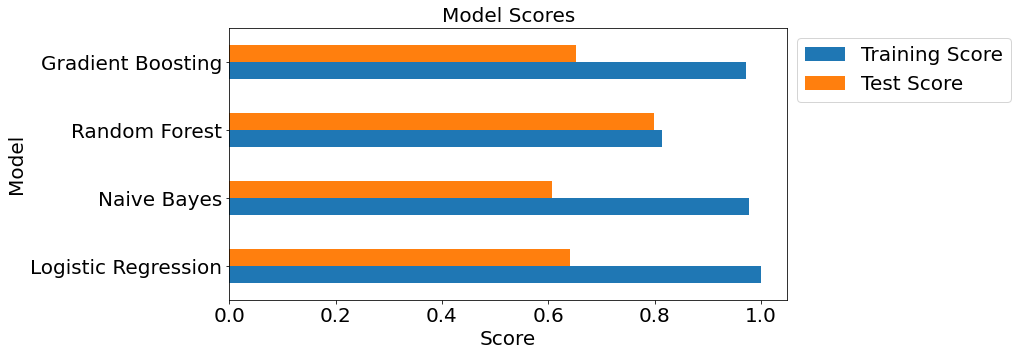

In [108]:
# Model Scores
grid_countvec_df.plot.barh(x='Model', y=['Training Score', 'Test Score'],
                          figsize=(10, 5), fontsize=20)
plt.xlabel('Score', fontsize=20)
plt.ylabel('Model', fontsize=20)
plt.title('Model Scores', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.show()

In [75]:
# Model/TfidfVec Performance
grid_tfidfvec_df

,Model,Best Parameters,Training Score,Test Score
0,Logistic Regression,"{'clf_logreg__C': 100.0, 'clf_logreg__random_s...",0.667885,0.581923
1,Naive Bayes,{'clf_naivebayes__alpha': 0.01},0.956394,0.608077
2,Random Forest,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.836250,0.791923
3,Gradient Boosting,"{'clf_gradboost__random_state': 42, 'clf_gradb...",0.965144,0.634231


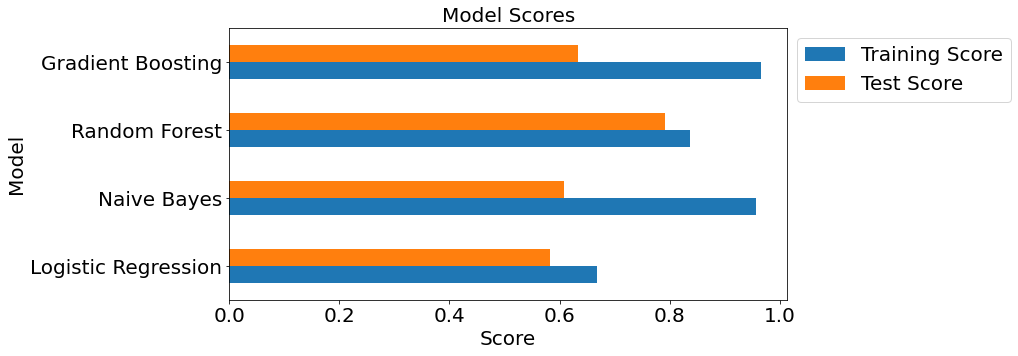

In [109]:
# Model Scores
grid_tfidfvec_df.plot.barh(x='Model', y=['Training Score', 'Test Score'],
                          figsize=(10, 5), fontsize=20)
plt.xlabel('Score', fontsize=20)
plt.ylabel('Model', fontsize=20)
plt.title('Model Scores', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.show()

---------------------------------
Confusion Matrix: Logistic Regression/CountVec


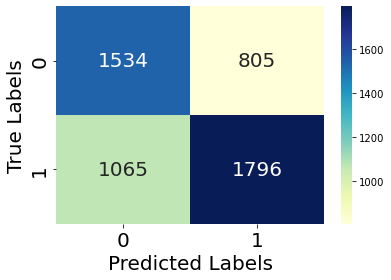

Classification Report: Logistic Regression/CountVec


,precision,recall,f1-score,support
0,0.590227,0.655836,0.621304,2339.000000
1,0.690504,0.627753,0.657635,2861.000000
accuracy,0.640385,0.640385,0.640385,0.640385
macro avg,0.640365,0.641794,0.639469,5200.000000
weighted avg,0.645398,0.640385,0.641293,5200.000000


---------------------------------
Confusion Matrix: Naive Bayes/CountVec


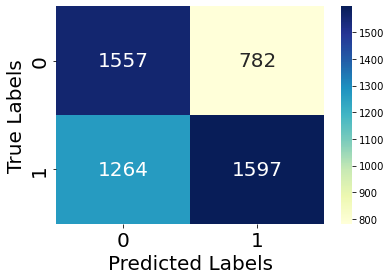

Classification Report: Naive Bayes/CountVec


,precision,recall,f1-score,support
0,0.551932,0.665669,0.603488,2339.000000
1,0.671290,0.558196,0.609542,2861.000000
accuracy,0.606538,0.606538,0.606538,0.606538
macro avg,0.611611,0.611933,0.606515,5200.000000
weighted avg,0.617602,0.606538,0.606819,5200.000000


---------------------------------
Confusion Matrix: Random Forest/CountVec


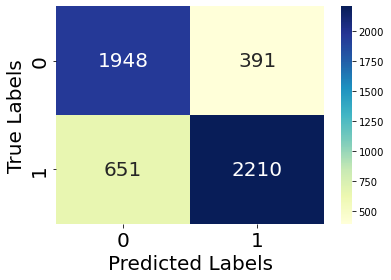

Classification Report: Random Forest/CountVec


,precision,recall,f1-score,support
0,0.749519,0.832835,0.788983,2339.000000
1,0.849673,0.772457,0.809227,2861.000000
accuracy,0.799615,0.799615,0.799615,0.799615
macro avg,0.799596,0.802646,0.799105,5200.000000
weighted avg,0.804623,0.799615,0.800121,5200.000000


---------------------------------
Confusion Matrix: Gradient Boosting/CountVec


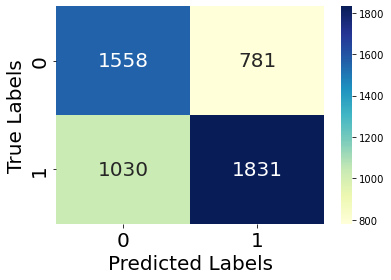

Classification Report: Gradient Boosting/CountVec


,precision,recall,f1-score,support
0,0.602009,0.666097,0.632434,2339.000000
1,0.700995,0.639986,0.669103,2861.000000
accuracy,0.651731,0.651731,0.651731,0.651731
macro avg,0.651502,0.653041,0.650768,5200.000000
weighted avg,0.656471,0.651731,0.652609,5200.000000


---------------------------------
Confusion Matrix: Logistic Regression/TfidfVec


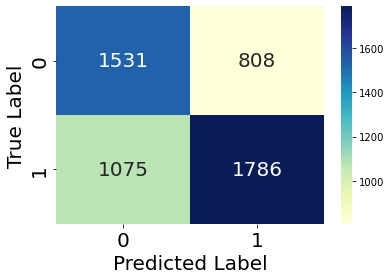

Classification Report: Logistic Regression/TfidfVec


,precision,recall,f1-score,support
0,0.587490,0.654553,0.619211,2339.000000
1,0.688512,0.624257,0.654812,2861.000000
accuracy,0.637885,0.637885,0.637885,0.637885
macro avg,0.638001,0.639405,0.637012,5200.000000
weighted avg,0.643072,0.637885,0.638799,5200.000000


---------------------------------
Confusion Matrix: Naive Bayes/TfidfVec


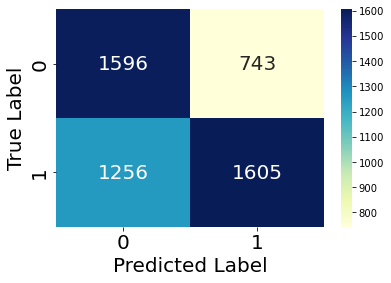

Classification Report: Naive Bayes/TfidfVec


,precision,recall,f1-score,support
0,0.559607,0.682343,0.614910,2339.000000
1,0.683560,0.560993,0.616241,2861.000000
accuracy,0.615577,0.615577,0.615577,0.615577
macro avg,0.621584,0.621668,0.615576,5200.000000
weighted avg,0.627805,0.615577,0.615643,5200.000000


---------------------------------
Confusion Matrix: Random Forest/TfidfVec


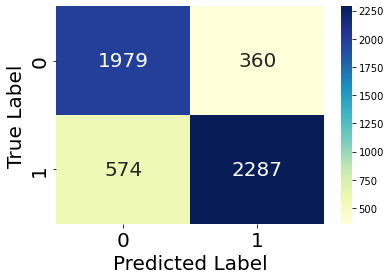

Classification Report: Random Forest/TfidfVec


,precision,recall,f1-score,support
0,0.775166,0.846088,0.809076,2339.000000
1,0.863997,0.799371,0.830428,2861.000000
accuracy,0.820385,0.820385,0.820385,0.820385
macro avg,0.819582,0.822729,0.819752,5200.000000
weighted avg,0.824040,0.820385,0.820824,5200.000000


---------------------------------
Confusion Matrix: Gradient Boosting/TfidfVec


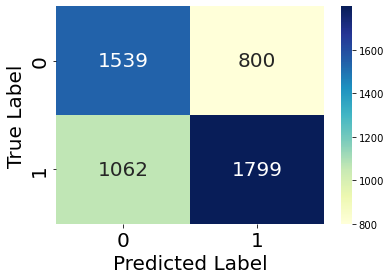

Classification Report: Gradient Boosting/TfidfVec


,precision,recall,f1-score,support
0,0.591696,0.657973,0.623077,2339.000000
1,0.692189,0.628801,0.658974,2861.000000
accuracy,0.641923,0.641923,0.641923,0.641923
macro avg,0.641942,0.643387,0.641026,5200.000000
weighted avg,0.646986,0.641923,0.642827,5200.000000


In [137]:
# Preliminary report on model performance
for i, model in enumerate(grids_countvec):
    print('---------------------------------')
    print("Confusion Matrix: {}/{}".format(grid_dict_countvec[i], 'CountVec'))
    cm = confusion_matrix(y_test, model.predict(X_countvec_test))
    sns.heatmap(cm, annot=True, annot_kws={'fontsize': 20}, cmap='YlGnBu', fmt='d')
    plt.xlabel('Predicted Labels', fontsize = 20)
    plt.ylabel('True Labels', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()
    print("Classification Report: {}/{}".format(grid_dict_countvec[i], 'CountVec'))
    display(pd.DataFrame(classification_report(y_test, model.predict(X_countvec_test), output_dict=True)).transpose())
    
for i, model in enumerate(grids_tfidfvec):
    print('---------------------------------')
    print("Confusion Matrix: {}/{}".format(grid_dict_tfidfvec[i], 'TfidfVec'))
    cm = confusion_matrix(y_test, model.predict(X_tfidfvec_test))
    sns.heatmap(cm, annot=True, annot_kws={'fontsize': 20}, cmap='YlGnBu', fmt='d')
    plt.xlabel('Predicted Label', fontsize = 20)
    plt.ylabel('True Label', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()
    print("Classification Report: {}/{}".format(grid_dict_tfidfvec[i], 'TfidfVec'))
    display(pd.DataFrame(classification_report(y_test, model.predict(X_tfidfvec_test), output_dict=True)).transpose())

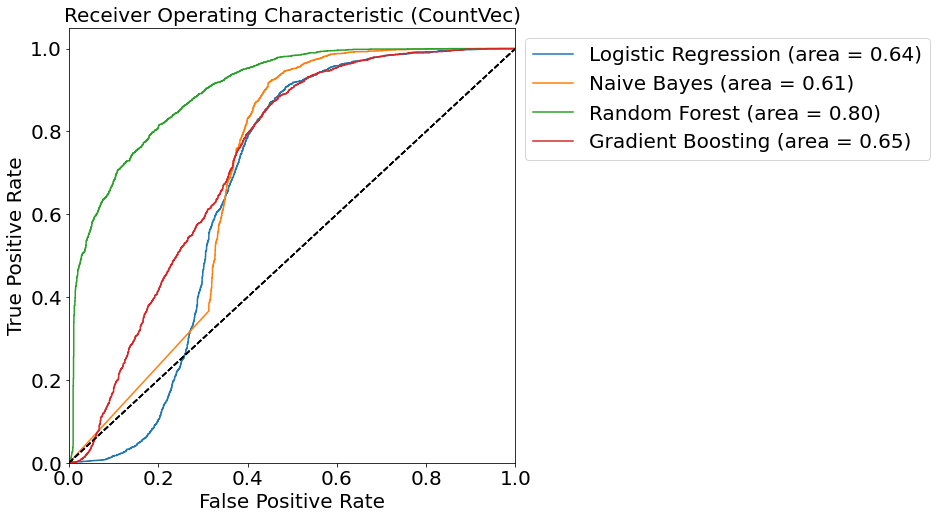

In [176]:
# Plotting ROC curves with AUC scores
plt.figure(figsize = (8, 8))
for i, model in enumerate(grids_countvec):
    # Compute ROC/AUC scores
    roc_auc = roc_auc_score(y_test, model.predict(X_countvec_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_countvec_test)[:,1])
    
    plt.plot(fpr, tpr, label=f'{grid_dict_countvec[i]} (area = {roc_auc:.2f})')
    plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('Receiver Operating Characteristic (CountVec)', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    plt.legend(bbox_to_anchor=(1, 1), fontsize=20)

plt.show()

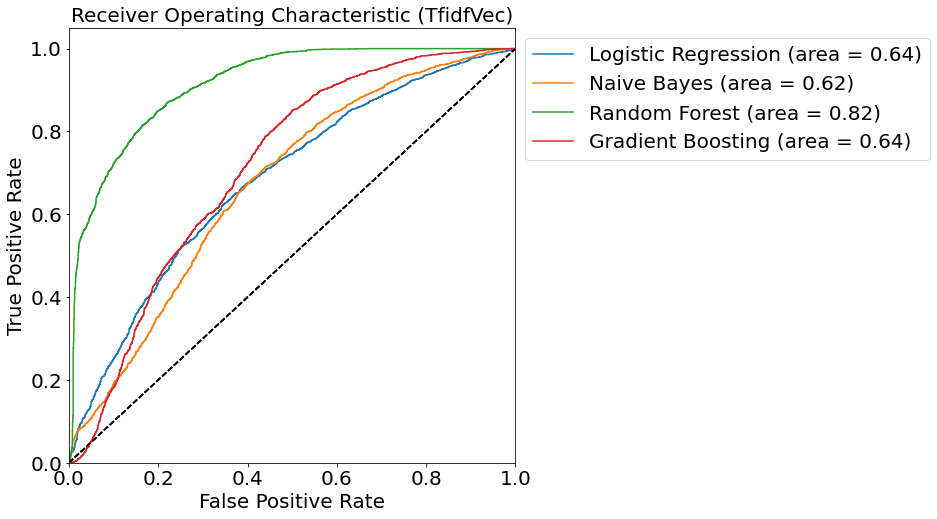

In [177]:
# Plotting ROC curves with AUC scores
plt.figure(figsize = (8, 8))
for i, model in enumerate(grids_tfidfvec):
    # Compute ROC/AUC scores
    roc_auc = roc_auc_score(y_test, model.predict(X_tfidfvec_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_tfidfvec_test)[:,1])
    
    plt.plot(fpr, tpr, label=f'{grid_dict_tfidfvec[i]} (area = {roc_auc:.2f})')
    plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('Receiver Operating Characteristic (TfidfVec)', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    plt.legend(bbox_to_anchor=(1, 1), fontsize=20)

plt.show()

Of the four classifier models, it would appear that Random Forest (5-fold cross-validation with randomized search) has performed the best at around 80-82% accuracy on the test set. Metric-wise, it also has the best precision, recall, and AUC score as shown in the ROC curves above.

While the other models generally fare better in the training set (typically in the 90+%), where their scores are typically higher than that of random forest they peformed much worse when applying them to the test set. This is likely a case of overfitting and/or not generalizing well. Random Forest, on the other hand, seems fairly consistent, maintaining roughly the same scores between training and test sets.

The performance of Logistic Regression (5-fold cross-validation with grid search) and Gradient Boosting (5-fold cross-validation with randomized search) for the test set, as mentioned earlier were much worse than Random Forest at roughly 64-65%. The worst performing model was Naive Bayes (5-fold cross-validation with grid search) at 61-62%.

With regards to computational cost, Gradient Boosting was the most expensive, taking nearly 3 hrs to complete, and the least expensive was Naive Bayes at 8 sec. Logistic Regression and Random Forest took roughly the same time to complete at around 11-12 minutes. It is important to note that the hyperparameters for the Random Forest and Gradient Boosting models were created through Randomized Search, which is less rigorous than a grid search, significantly speeding up their processes.

With regards to word vectorization, neither approaches (Count Vectorization or TF-IDF Vectorization) provide a significant improvement over the other when it comes to model performance. Models that utilizes TF-IDF is, however, slightly better than their Count Vec counterparts.

Moving forward, we could see if we could improve upon the Random Forest Model we have now by running a more rigorous hyperparameter grid search as opposed to a randomized search and by widening our parameter space. As to which word vectorization approach to go for, we'll utilize the TF-IDF approach which provides slightly better results than Count Vectorization.

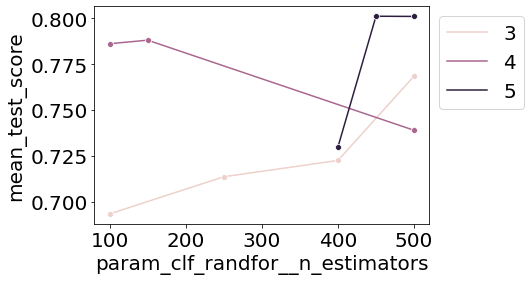

In [212]:
# Checking best parameters for previous randfor model
cv_results_randfor = pd.DataFrame(grid_tfidfvec_randfor_5cv.cv_results_).sort_values('rank_test_score')
sns.lineplot(data=cv_results_randfor, x='param_clf_randfor__n_estimators', y='mean_test_score',
                hue='param_clf_randfor__max_depth', marker='o')
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.show()

In [195]:
cv_results_randfor

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf_randfor__random_state,param_clf_randfor__n_estimators,param_clf_randfor__max_features,param_clf_randfor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,11.795894,0.044175,3.065306,0.017677,42,450,sqrt,5,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.785817,0.793510,0.806010,0.812019,0.808173,0.801106,0.009844,1
0,13.015359,0.152935,3.413731,0.033252,42,500,sqrt,5,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.790385,0.794471,0.805769,0.807452,0.806971,0.801010,0.007146,2
4,3.348317,0.052596,1.033550,0.013370,42,150,sqrt,4,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.774519,0.765865,0.801923,0.798798,0.799279,0.788077,0.014895,3
9,2.360384,0.026851,0.697537,0.008853,42,100,sqrt,4,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.791346,0.756971,0.803606,0.779808,0.799038,0.786154,0.016670,4
6,8.013318,0.041704,3.471825,0.186033,42,500,sqrt,3,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.754567,0.759135,0.767308,0.777163,0.784375,0.768510,0.011048,5
2,3.134071,0.026390,3.372127,0.028257,42,500,log2,4,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.719471,0.752885,0.739183,0.742548,0.741106,0.739038,0.010874,6
5,2.882454,0.036889,2.725268,0.013837,42,400,log2,5,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.711779,0.740625,0.731731,0.730769,0.734856,0.729952,0.009717,7
7,2.320086,0.105485,2.730279,0.051162,42,400,log2,3,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.700000,0.731971,0.723317,0.727885,0.729808,0.722596,0.011653,8
3,1.564937,0.012569,1.714674,0.019153,42,250,log2,3,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.691346,0.715865,0.714904,0.717548,0.729087,0.713750,0.012308,9
8,0.827335,0.011648,0.696859,0.007049,42,100,log2,3,"{'clf_randfor__random_state': 42, 'clf_randfor...",0.670192,0.693990,0.712019,0.690385,0.700962,0.693510,0.013797,10


From the cross validation results of the previous model, we could see that the best scoring models has a relatively high number of estimators and/or a pretty deep max depth. One thing to note in this case is that a large number of estimators could help improve the scores for models with smaller max depth as seen with max depth = 3 and n_estimators = 500. We could try and expand on n_estimators in our parameter space to see if this trend would continue. We'll also test out deeper trees up to max depth = 7 as increasing max depth does seem improve upon our scores, although it might as well just be overfitting.

Models that utilizes log2 appears to perform worse overall when compared to using the sqrt approach for deriving max features. Thus, we'll just be utilizing sqrt in our new search.

In [196]:
# Setting up new pipeline for Random Forest Classifier
pipe_tfidfvec_randfor2 = Pipeline([('clf', RandomForestClassifier())])

parameters = {'clf__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700],
              'clf__max_depth': [3, 4, 5, 6, 7],
              'clf__max_features': ['sqrt'],
              'clf__random_state': [42]}

In [198]:
# Running exhaustive grid serach for Random Forest Classifier with 5-fold cross-validation
grid_tfidfvec_randfor2_5cv = GridSearchCV(pipe_tfidfvec_randfor2, parameters, cv=5).fit(X_tfidfvec, y)

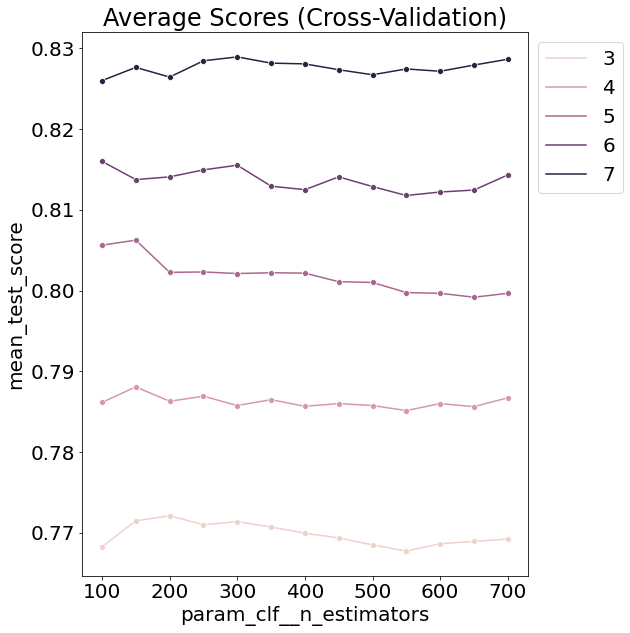

In [217]:
# Checking scores from cross validation
plt.figure(figsize = (8, 10))
cv_results_randfor2 = pd.DataFrame(grid_tfidfvec_randfor2_5cv.cv_results_).sort_values('rank_test_score')
sns.lineplot(data=cv_results_randfor2, x='param_clf__n_estimators', y='mean_test_score',
                hue='param_clf__max_depth', marker='o')
plt.title('Average Scores (Cross-Validation)')
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.show()

In [204]:
# Best parameters based on cross validation
grid_tfidfvec_randfor2_5cv.best_params_

{'clf__max_depth': 7,
 'clf__max_features': 'sqrt',
 'clf__n_estimators': 300,
 'clf__random_state': 42}

---------------------------------
Confusion Matrix: Random Forest Classifier/TfidfVec


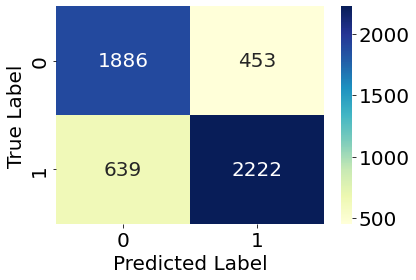

Classification Report: Random Forest Classifier/TfidfVec


,precision,recall,f1-score,support
0,0.746931,0.806327,0.775493,2339.00
1,0.830654,0.776652,0.802746,2861.00
accuracy,0.790000,0.790000,0.790000,0.79
macro avg,0.788792,0.791490,0.789120,5200.00
weighted avg,0.792995,0.790000,0.790487,5200.00


In [203]:
# Checking model performance
print('---------------------------------')
print("Confusion Matrix: {}/{}".format('Random Forest Classifier', 'TfidfVec'))
cm = confusion_matrix(y_test, grid_tfidfvec_randfor2_5cv.predict(X_tfidfvec_test))
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 20}, cmap='YlGnBu', fmt='d')
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('True Label', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
print("Classification Report: {}/{}".format('Random Forest Classifier', 'TfidfVec'))
display(pd.DataFrame(classification_report(y_test, grid_tfidfvec_randfor2_5cv.predict(X_tfidfvec_test), output_dict=True)).transpose())

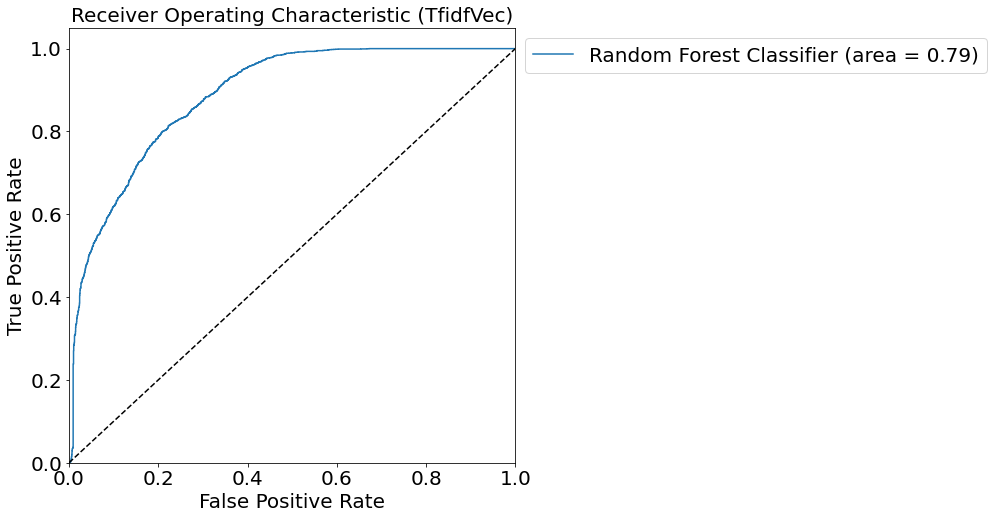

In [210]:
# Plotting ROC curves with AUC scores
plt.figure(figsize = (8, 8))

# Compute ROC/AUC scores
roc_auc = roc_auc_score(y_test, grid_tfidfvec_randfor2_5cv.predict(X_tfidfvec_test))
fpr, tpr, thresholds = roc_curve(y_test, grid_tfidfvec_randfor2_5cv.predict_proba(X_tfidfvec_test)[:,1])
    
plt.plot(fpr, tpr, label=f'Random Forest Classifier (area = {roc_auc:.2f})')
plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
    
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic (TfidfVec)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
    
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.show()

Seeing how increasing max depth is lowering our test score, it does appear max depth is worsening our model performance by overfitting.

Perhaps we could try out models with lower max depth, but still have high mean scores from cross validation:
- estimators = 150, max depth = 5
- estimators = 150, max depth = 4
- estimators = 200, max depth = 3

In [218]:
# Building models for Random Forest Classifier using the criterions stated above
randfor_150_5 = RandomForestClassifier(n_estimators = 150, max_depth = 5, max_features = 'sqrt', random_state = 42)
randfor_150_4 = RandomForestClassifier(n_estimators = 150, max_depth = 4, max_features = 'sqrt', random_state = 42)
randfor_200_3 = RandomForestClassifier(n_estimators = 200, max_depth = 3, max_features = 'sqrt', random_state = 42)

randfor_150_5.fit(X_tfidfvec, y)
randfor_150_4.fit(X_tfidfvec, y)
randfor_200_3.fit(X_tfidfvec, y)

y_pred_150_5 = randfor_150_5.predict(X_tfidfvec_test)
y_pred_150_4 = randfor_150_4.predict(X_tfidfvec_test)
y_pred_200_3 = randfor_200_3.predict(X_tfidfvec_test)

In [224]:
randfor_models = [randfor_150_5,
                  randfor_150_4,
                  randfor_200_3]

randfor_model_predictions = [y_pred_150_5,
                             y_pred_150_4,
                             y_pred_200_3]

randfor_model_dict = {0: 'Estimator = 150, Max Depth = 5',
                      1: 'Estimator = 150, Max Depth = 4',
                      2: 'Estimator = 200, Max Depth = 3'}

---------------------------------
Confusion Matrix: Estimator = 150, Max Depth = 5


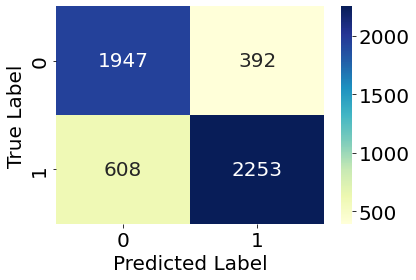

Classification Report: Estimator = 150, Max Depth = 5


,precision,recall,f1-score,support
0,0.762035,0.832407,0.795668,2339.000000
1,0.851796,0.787487,0.818380,2861.000000
accuracy,0.807692,0.807692,0.807692,0.807692
macro avg,0.806916,0.809947,0.807024,5200.000000
weighted avg,0.811421,0.807692,0.808164,5200.000000


---------------------------------
Confusion Matrix: Estimator = 150, Max Depth = 4


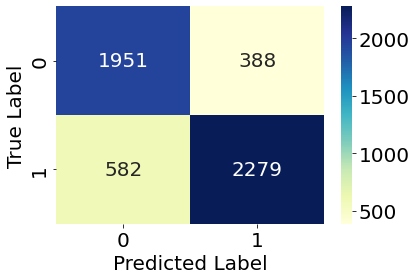

Classification Report: Estimator = 150, Max Depth = 4


,precision,recall,f1-score,support
0,0.770233,0.834117,0.800903,2339.000000
1,0.854518,0.796575,0.824530,2861.000000
accuracy,0.813462,0.813462,0.813462,0.813462
macro avg,0.812376,0.815346,0.812716,5200.000000
weighted avg,0.816606,0.813462,0.813902,5200.000000


---------------------------------
Confusion Matrix: Estimator = 200, Max Depth = 3


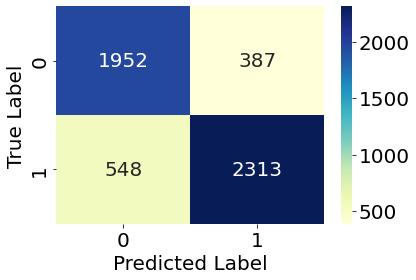

Classification Report: Estimator = 200, Max Depth = 3


,precision,recall,f1-score,support
0,0.780800,0.834545,0.806778,2339.000000
1,0.856667,0.808459,0.831865,2861.000000
accuracy,0.820192,0.820192,0.820192,0.820192
macro avg,0.818733,0.821502,0.819322,5200.000000
weighted avg,0.822541,0.820192,0.820581,5200.000000


In [227]:
# Checking model performance
for i, model_prediction in enumerate(randfor_model_predictions):
    print('---------------------------------')
    print("Confusion Matrix: {}".format(randfor_model_dict[i]))
    cm = confusion_matrix(y_test, model_prediction)
    sns.heatmap(cm, annot=True, annot_kws={'fontsize': 20}, cmap='YlGnBu', fmt='d')
    plt.xlabel('Predicted Label', fontsize = 20)
    plt.ylabel('True Label', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()
    print("Classification Report: {}".format(randfor_model_dict[i]))
    display(pd.DataFrame(classification_report(y_test, model_prediction, output_dict=True)).transpose())

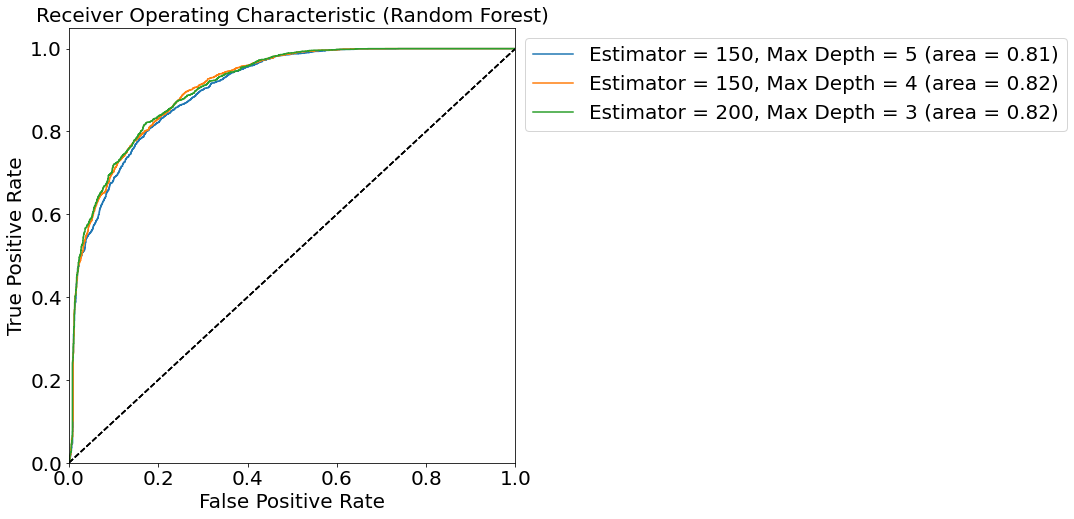

In [225]:
# Plotting ROC curves with AUC scores
plt.figure(figsize = (8, 8))
for i, model in enumerate(randfor_models):
    # Compute ROC/AUC scores
    roc_auc = roc_auc_score(y_test, model.predict(X_tfidfvec_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_tfidfvec_test)[:,1])
    
    plt.plot(fpr, tpr, label=f'{randfor_model_dict[i]} (area = {roc_auc:.2f})')
    plt.plot([0.0, 1.0], [0.0, 1.0], 'k--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('Receiver Operating Characteristic (Random Forest)', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    plt.legend(bbox_to_anchor=(1, 1), fontsize=20)

plt.show()

Of the three selected Random Forest Classifiers, each model provide a similar level of performance. However, the model with 200 estimators and a max depth of 3 edges out in terms of AUC score, precision score, recall score, f1 score, and accurary.

We could check out the cases where the model has failed however.

In [241]:
# Storing indexes with incorrect predictions
wrong_prediction_index = []

for i, prediction in enumerate(y_pred_200_3):
    if prediction != y_test[i]:
        wrong_prediction_index.append(i)

In [243]:
# Checking failed cases from test set
wrong_predictions = df_test.loc[wrong_prediction_index]
wrong_predictions_true_stories = wrong_predictions[wrong_predictions['label'] == 0]
wrong_predictions_fake_stories = wrong_predictions[wrong_predictions['label'] == 1]

In [244]:
wrong_predictions_true_stories.head()

,id,title,author,text,label,merged
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0,#NoDAPL: Native American Leaders Vow to Stay A...
8,20808,Urban Population Booms Will Make Climate Chang...,noauthor,Urban Population Booms Will Make Climate Chang...,0,Urban Population Booms Will Make Climate Chang...
10,20810,184 U.S. generals and admirals endorse Trump f...,Dr. Eowyn,Have you seen that pro-Hillary TV ad of disgra...,0,184 U.S. generals and admirals endorse Trump f...
12,20812,The Rise of Mandatory Vaccinations Means the E...,Shaun Bradley,Written by Shaun Bradley Mandatory vaccinati...,0,The Rise of Mandatory Vaccinations Means the E...
22,20822,notitle,Dale Johnson,VERSE 9. THE STATE OF NATIONAL INSECURITY The ...,0,notitle Dale Johnson VERSE 9. THE STATE OF NAT...


In [245]:
wrong_predictions_fake_stories.head()

,id,title,author,text,label,merged
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1,"Tim Tebow Will Attempt Another Comeback, This ..."
41,20841,Trump: Confidence In Economy ’Has Reached Leve...,Ian Hanchett,"During Friday’s Weekly Address, President Trum...",1,Trump: Confidence In Economy ’Has Reached Leve...
46,20846,Exclusive-Rep. Dave Brat: RyanCare a Perverse ...,Neil W. McCabe,Virginia Republican congressman Dave Brat told...,1,Exclusive-Rep. Dave Brat: RyanCare a Perverse ...
59,20859,"Kunduz Attack in November Killed 33 Civilians,...",Mujib Mashal,"KABUL, Afghanistan — A United States milita...",1,"Kunduz Attack in November Killed 33 Civilians,..."
79,20879,High School Basketball Player Scores an Amazin...,Warner Todd Huston,A California high school basketball player has...,1,High School Basketball Player Scores an Amazin...


In [265]:
# We can use WordCloud to visualize what was the most common words in these incorrect predictions
from wordcloud import WordCloud, STOPWORDS

In [255]:
string_data_true_story = ' '.join(list(wrong_predictions_true_stories['merged'].values))
string_data_fake_story = ' '.join(list(wrong_predictions_fake_stories['merged'].values))

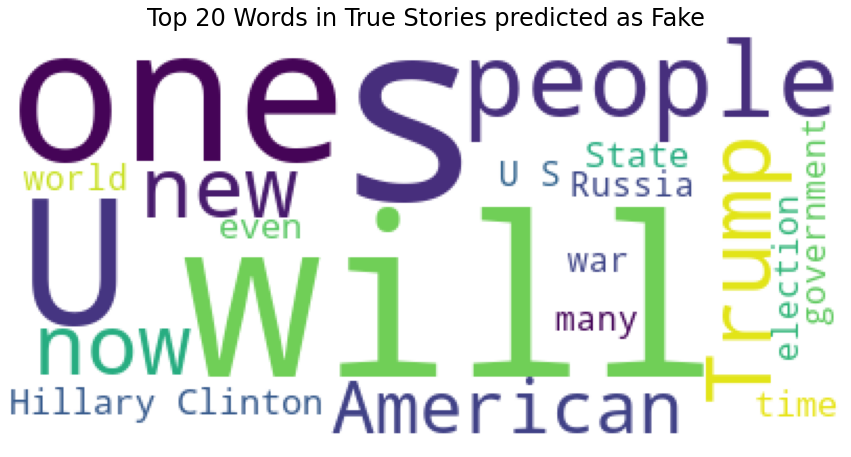

In [279]:
# Building simple word cloud
wordcloud = WordCloud(stopwords = STOPWORDS,
                      background_color='white',
                      max_words=20).generate(string_data_true_story)

plt.figure(figsize=(15, 15))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Top 20 Words in True Stories predicted as Fake")
plt.show()

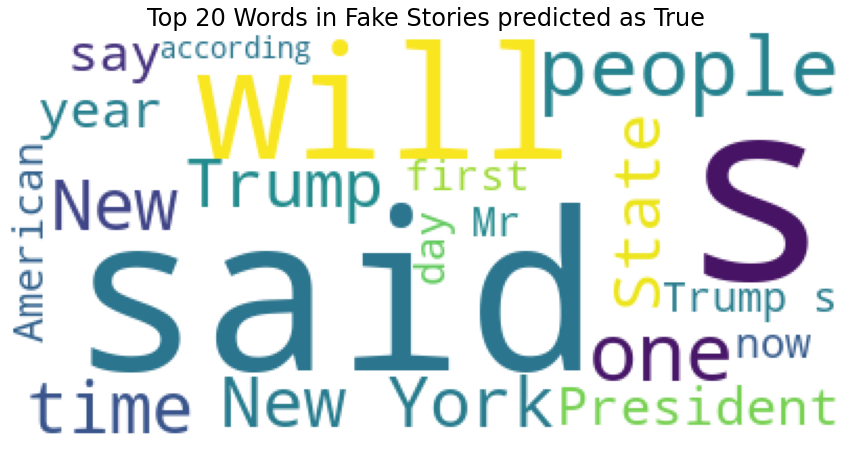

In [280]:
# Building simple word cloud
wordcloud = WordCloud(stopwords = STOPWORDS,
                      background_color='white',
                      max_words=20).generate(string_data_fake_story)

plt.figure(figsize=(15, 15))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Top 20 Words in Fake Stories predicted as True")
plt.show()

From these word clouds, we could see that the model is having a difficult time predicting topics that might be considered highly political.

Words like Trump, people, American, Hilary Clinton, Russia, election were considered as part of "fake news" by the model despite being true.

On the same note, words like Trump, New York, President, State, people, according were considered as part of "true stories" by the model despite being fake.

One thing we might consider trying is to introduce sentiment analysis features along with the word vectors.

For now, we'll save this model as our current predictor.

In [281]:
# Import Dependencies for Model Saving
import joblib

In [286]:
# Path to model_file directory
model_file_dir = os.path.join(main_dir, 'model_files')
dump_file = os.path.join(model_file_dir, 'randfor_model_200_3')

In [287]:
print(dump_file)

/Users/Lee/Projects/random_codes/machine_learning_practice/fake_news_dataset/model_files/randfor_model_200_3


In [288]:
# Save best performing model as joblib file
joblib.dump(randfor_200_3, dump_file + '.joblib')

# Save best performing model as a compressed bz2 file
joblib.dump(randfor_200_3, dump_file + '.bz2', compress=('bz2', 3))

['/Users/Lee/Projects/random_codes/machine_learning_practice/fake_news_dataset/model_files/randfor_model_200_3.bz2']

In [291]:
# Saving TF-IDF vectorizer as joblib file
vectorizer_file_dir = os.path.join(main_dir, 'vectorizer_files')
dump_file_vectorizer = os.path.join(vectorizer_file_dir, 'tfidf_vectorizer')
joblib.dump(tfidfvec, dump_file_vectorizer + '.joblib')

['/Users/Lee/Projects/random_codes/machine_learning_practice/fake_news_dataset/vectorizer_files/tfidf_vectorizer.joblib']

In [292]:
y_pred_200_3

array([0, 1, 1, ..., 0, 1, 0])

In [294]:
df_test['predicted'] = y_pred_200_3

In [295]:
df_test

,id,title,author,text,label,merged,predicted
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0,"Specter of Trump Loosens Tongues, if Not Purse...",0
1,20801,Russian warships ready to strike terrorists ne...,noauthor,Russian warships ready to strike terrorists ne...,1,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0,#NoDAPL: Native American Leaders Vow to Stay A...,1
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1,"Tim Tebow Will Attempt Another Comeback, This ...",0
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1,Keiser Report: Meme Wars (E995) Truth Broadcas...,1
...,...,...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,0,The Bangladeshi Traffic Jam That Never Ends - ...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,1,John Kasich Signs One Abortion Bill in Ohio bu...,0
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,0,"California Today: What, Exactly, Is in Your Su...",0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,noauthor,« Previous - Next » 300 US Marines To Be Deplo...,1,300 US Marines To Be Deployed To Russian Borde...,1
